In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from pprint import pprint

from NBodyF.utils.io import load_system
from NBodyF.core.utils import calc_eccentricity, calc_semi_major_axis
from NBodyF.core.units import *
from NBodyF.core.constants import M_jup, M_sat

In [3]:
sns.set_style('ticks')

In [18]:
path_file = "simulation/template_hb_JS.h5"
path_info = "info/"

include_js = False

# Init System

In [19]:
r, v, m, ms, tm, par = load_system(path_file)#, iteration=5000)
r = np.array(r)
v = np.array(v)
m = np.array(m)
ms = np.array(ms)

In [20]:
m0_star = par["m_star"]
a_max = par['a_max'] * LU_to_UA + 1
record = par["record"]
name = par["name"]

In [21]:
pprint(par)

{'a_max': 1.1747216922201065,
 'a_min': 0.8810412691650799,
 'add_jup_sat': True,
 'density': 199348833.52758622,
 'dim': 2,
 'dmin': 0.058736084611005324,
 'dt': 0.01643835616438356,
 'fmg_max': 5,
 'fmg_min': 1,
 'fmp_max': 0.0333,
 'fmp_min': 0.01,
 'integrator': 'HS_BS_FRAG',
 'last_iteration': 121,
 'last_time': 19.890410958904067,
 'm_o': 1.6514923759872508e-07,
 'm_star': 1.0,
 'model_jup_sat': 'JS',
 'n1': 3.0,
 'n2': 0.4,
 'n_g': 10,
 'n_p': 20,
 'name': 'template_hb_JS',
 'record': 10,
 'tf': 20.0}


# Initial System

## Initial Mass Distribution

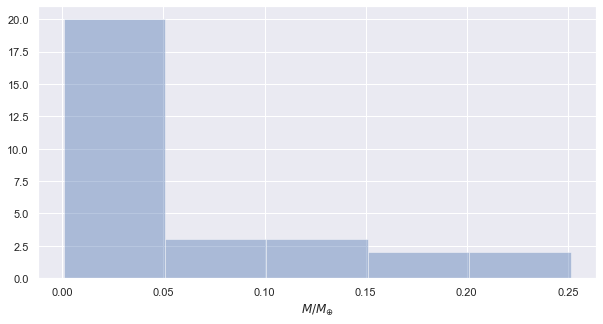

In [22]:
sns.set(rc={"figure.figsize": (10, 5)})

if include_js:
    ax = sns.distplot(m[0][:, 0] * MU_to_ME, kde=False)
else:
    ax = sns.distplot(m[0][(m[0] < M_sat).nonzero()[0], 0] * MU_to_ME, kde=False)

ax.set(xlabel=r'$M/M_{\oplus}$')

plt.show()

## Initial System

(-5, 5)

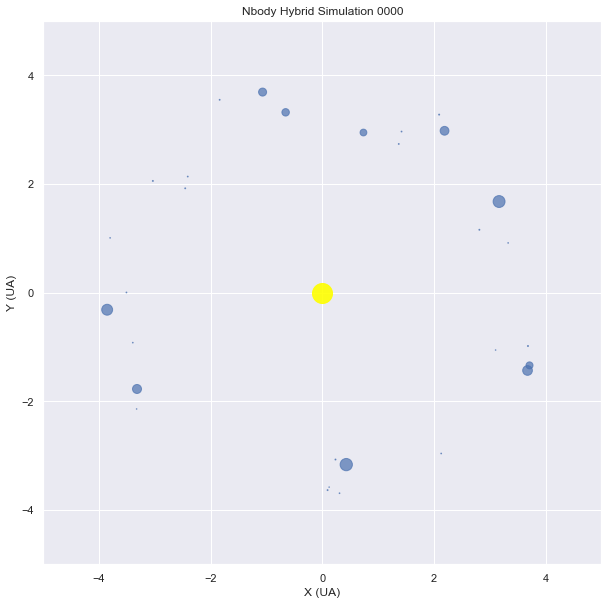

In [24]:
f = 400
dmax = 5

if include_js:
    x = r[0][:, 0, 0] * LU_to_UA
    y = r[0][:, 1, 0] * LU_to_UA
    mg = m[0][:, 0]
else:
    ind = (m[0] < M_sat).nonzero()[0]
    x = r[0][ind, 0, 0] * LU_to_UA
    y = r[0][ind, 1, 0] * LU_to_UA
    mg = m[0][ind, 0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(0., 0., alpha=0.90, c="Yellow", s=m0_star*f)
ax.scatter(x, y, alpha=0.70, s=mg*f*500000)

ax.set_title('Nbody Hybrid Simulation {0:04d}'.format(0))
ax.set_xlabel('X (UA)')
ax.set_ylabel('Y (UA)')
ax.set_xlim([-dmax,dmax])
ax.set_ylim([-dmax,dmax])
    

# Evolution

## Generating Images and Gif

In [25]:
def convert_t(t):
    if t <1e3:
        return "{:.2f} yrs".format(t)
    elif t<1e6:
        return "{:.2f} Kyrs".format(t/(1e3))
    else:
        return "{:.2f} Myrs".format(t/(1e6))

In [43]:
generate_img = True

f = 400
dmax = 5
folder_images = "frag"

if generate_img:
    i_t = 10

    for t in tqdm(range(len(r))):
        if include_js:
            x = r[t][:, 0, 0] * LU_to_UA
            y = r[t][:, 1, 0] * LU_to_UA
            mg = m[t][:, 0]
        else:
            ind = (m[t] < M_sat).nonzero()[0]
            x = r[t][ind, 0, 0] * LU_to_UA
            y = r[t][ind, 1, 0] * LU_to_UA
            mg = m[t][ind, 0]

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.scatter(0., 0., alpha=0.90, c="Yellow", s=ms[t]*f)
        ax.scatter(x, y, alpha=0.70, s=mg*f*500000)

        add_trace = True
        if add_trace:
            t_t = ((t + 1) - i_t) if t > i_t else 0

            for j in range(len(x)):
                x_trail = r[t_t:(t + 1), j, 0, 0] * LU_to_UA
                y_trail = r[t_t:(t + 1), j, 1, 0] * LU_to_UA
                ax.plot(x_trail, y_trail, linewidth=1., linestyle='dashed', color="black")

        # adds a title and axes labels
        ax.set_title("Nbody Hybrid Simulation {}".format(convert_t(tm[t])))
        ax.set_xlabel('X (UA)')
        ax.set_ylabel('Y (UA)')
        ax.set_xlim([-dmax,dmax])
        ax.set_ylim([-dmax,dmax])

        plt.savefig(path_info + "/" + folder_images + "/{0:08d}.png".format(t * record))
        plt.close()

100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [00:18<00:00,  6.70it/s]


In [46]:
generate_gif = True
if generate_gif:
    frames = []
    imgs = glob.glob(path_info + folder_images + "/" + "*.png")
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save(path_info + '{}.gif'.format(name), format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=100, loop=0)

## Number of Objects

In [32]:
n = list()
tl = list()
for t in range(len(r)):
    n.append(len(r[t]))
    tl.append(tm[t])

In [33]:
len(n)

122

In [35]:
import pandas as pd

In [36]:
data = pd.DataFrame.from_dict({"time" : tl, "n" : n})
data.head()

time   n
0  0.000000  32
1  0.164384  32
2  0.328767  32
3  0.493151  32
4  0.657534  32

In [38]:
#data.to_excel("data_n.xlsx")

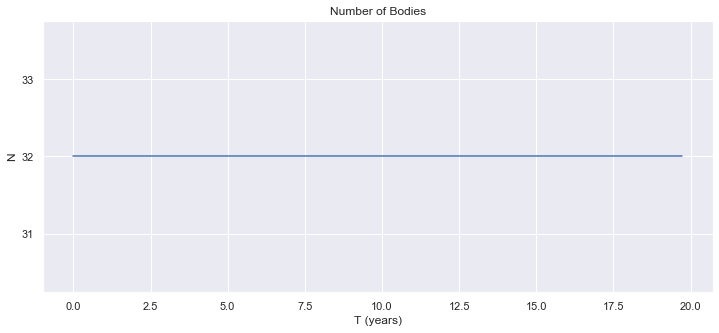

In [39]:
gg = -1
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl[:gg], n[:gg])

# ax.set_xscale('log')

# adds a title and axes labels
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Number of Bodies")
ax.set_xlabel('T (years)')
ax.set_ylabel('N')

plt.show()

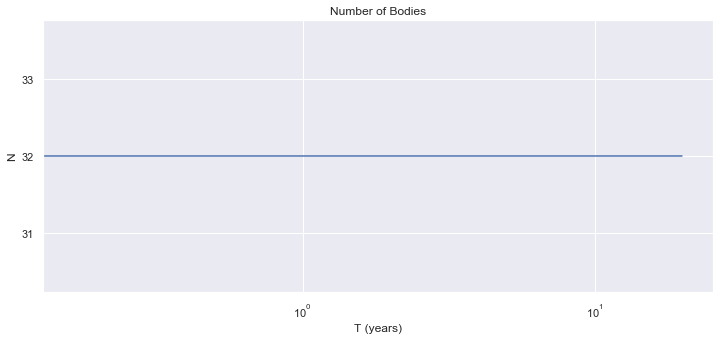

In [40]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, n)

ax.set_xscale('log')

# adds a title and axes labels
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Number of Bodies")
ax.set_xlabel('T (years)')
ax.set_ylabel('N')

plt.show()

## Energy

In [47]:
from NBodyF.core.forces import total_energy, potential_energy_ps

In [48]:
te0, pe0, ke0, _, _ = total_energy(r[0], v[0], m[0], m0_star)

In [49]:
tl = list()
te = list()
pe = list()
ps = list()
pp = list()
ke = list()
rte = list()
rpe = list()
rke = list()
virial = list()

for t in range(1, len(r)):
    tl.append(tm[t])
    temp_te, temp_pe, temp_ke, temp_pp, temp_ps = total_energy(r[t], v[t], m[t], ms[t])
    
    te.append(temp_te)
    pe.append(temp_pe)
    pp.append(temp_pp)
    ps.append(temp_ps)
    ke.append(temp_ke)
    
    rte.append((temp_te - te0) / te0)
    rpe.append((temp_pe - pe0) / pe0)
    rke.append((temp_ke - ke0) / ke0)
    
    virial.append(temp_pe + 2 * temp_ke)

In [50]:
import pandas as pd

In [51]:
data = pd.DataFrame.from_dict({"time" : tl, "relative_energy" : rte, "virial" : virial})
data.head()

time  relative_energy        virial
0  0.164384         0.000004 -1.089693e-06
1  0.328767         0.000007 -1.073921e-06
2  0.493151         0.000012 -1.049590e-06
3  0.657534         0.000016 -1.016919e-06
4  0.821918         0.000021 -9.762057e-07

In [52]:
data = pd.DataFrame.from_dict({"time" : tl, "relative_energy" : rte, "virial" : virial})
data.to_excel("data.xlsx")

### Total Energy

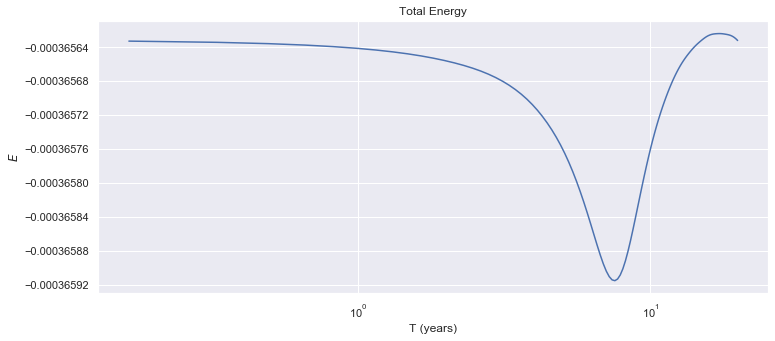

In [53]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, te)
ax.set_xscale('log')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Total Energy")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"$E$")

plt.show()

### Potential Energy

#### Potential Energy Planets-Planets

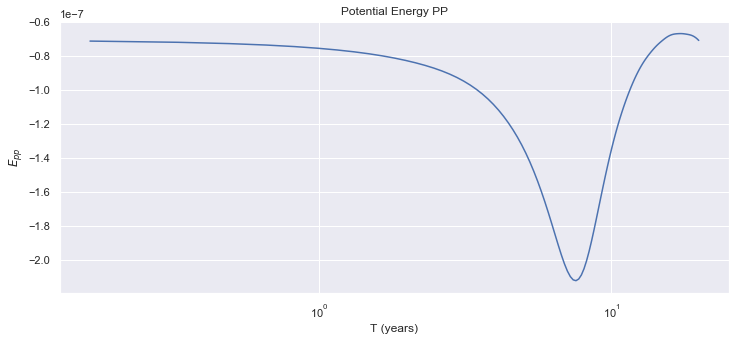

In [54]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, pp)
ax.set_xscale('log')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Potential Energy PP")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"$E_{pp}$")

plt.show()

#### Potential Energy Planets-Sun

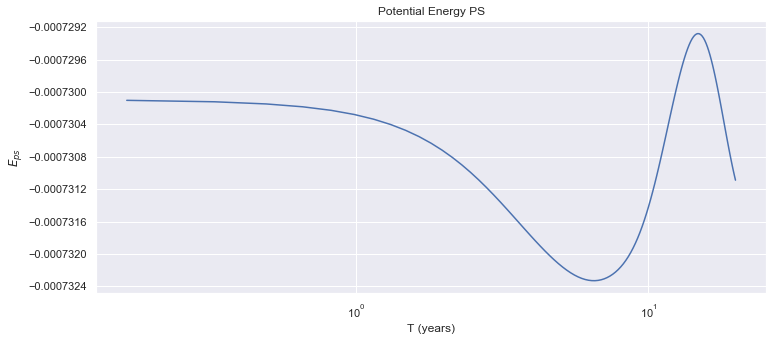

In [55]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, ps)
ax.set_xscale('log')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Potential Energy PS")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"$E_{ps}$")
# plt.ylim([-6.085e-6,-6.07e-6])
plt.show()

#### Total Potential Energy

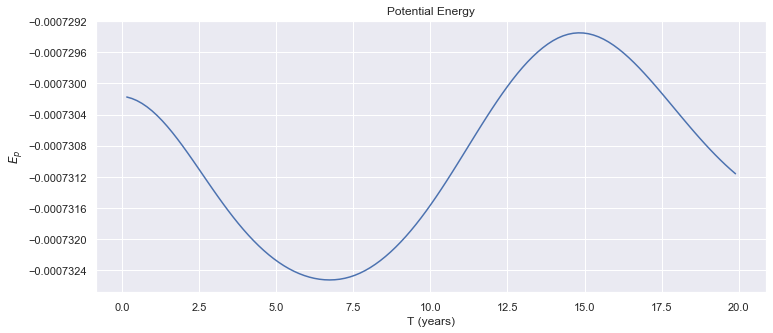

In [56]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, pe)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Potential Energy")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"$E_p$")

plt.show()

### Kinetic Energy

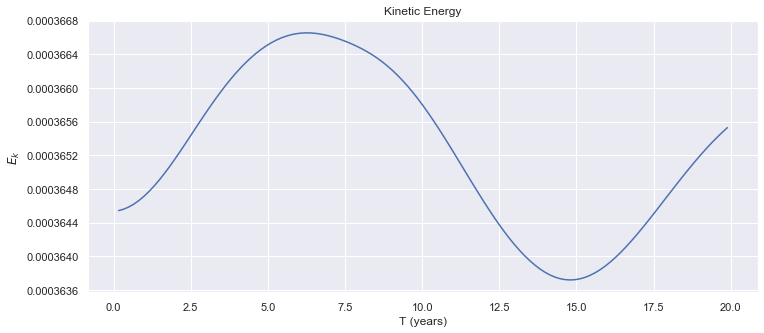

In [57]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, ke)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Kinetic Energy")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"$E_k$")

plt.show()

### Relative Error Total Energy

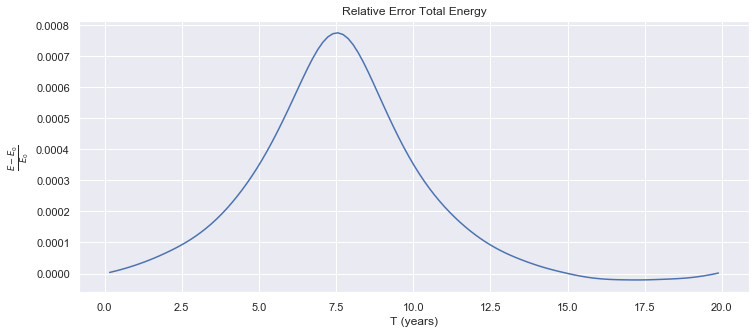

In [58]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, rte)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Relative Error Total Energy")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"$\frac{E - E_0}{E_0}$")
# plt.ylim([-1e-7,1.5e-6])
plt.show()

### Relative Error Potential Energy

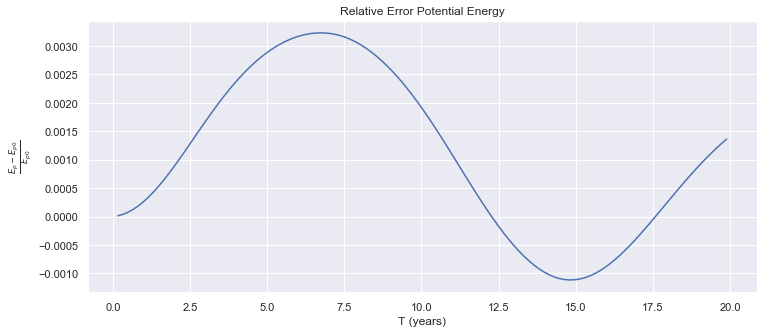

In [59]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, rpe)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Relative Error Potential Energy")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"$\frac{E_p - E_{p0}}{E_{p0}}$")

plt.show()

### Relative Error Kinetic Energy

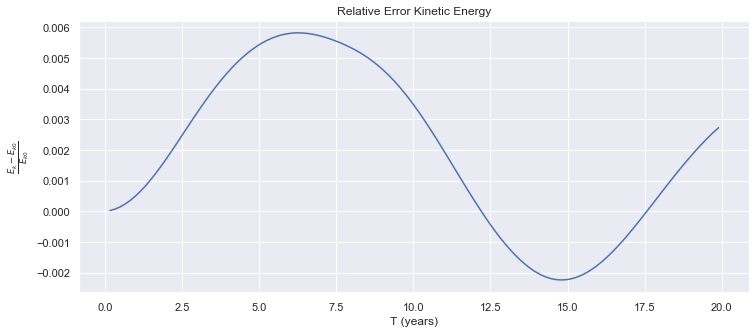

In [60]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, rke)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Relative Error Kinetic Energy")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"$\frac{E_k - E_{k0}}{E_{k0}}$")

plt.show()

### Virial Theorem

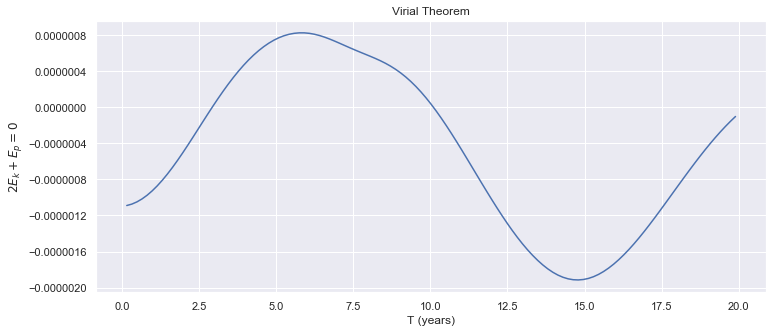

In [61]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, virial)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Virial Theorem")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"$2E_k + E_p = 0$")

plt.show()

## Eccentricity Weighted by Mass

In [62]:
local_include = False

ecc_mass = list()
tl = list()

if include_js or local_include:
    for t in range(len(r)):
        ecc = calc_eccentricity(r[t], v[t], m[t], ms[t])
        ecc_mass.append(np.sum(ecc* m[t])/np.sum(m[t]))
        tl.append(tm[t])
else:
    for t in range(len(r)):
        ind = (m[t] < M_sat).nonzero()[0]
        ecc = calc_eccentricity(r[t][ind], v[t][ind], m[t][ind], ms[t])
        ecc_mass.append(np.sum(ecc* m[t][ind])/np.sum(m[t][ind]))
        tl.append(tm[t])

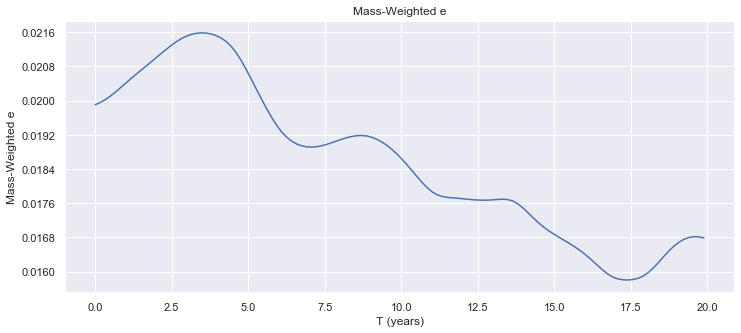

In [63]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, ecc_mass)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(r"Mass-Weighted e")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"Mass-Weighted e")

plt.show()

## Semi-major axis Weighted by Mass

In [64]:
local_include = False

ecc_mass = list()
tl = list()

if include_js or local_include:
    for t in range(len(r)):
        ecc = calc_semi_major_axis(r[t], v[t], m[t], ms[t]) * LU_to_UA
        ecc_mass.append(np.sum(ecc* m[t])/np.sum(m[t]))
        tl.append(tm[t])
else:
    for t in range(len(r)):
        ind = (m[t] < M_sat).nonzero()[0]
        ecc = calc_semi_major_axis(r[t][ind], v[t][ind], m[t][ind], ms[t]) * LU_to_UA
        ecc_mass.append(np.sum(ecc* m[t][ind])/np.sum(m[t][ind]))
        tl.append(tm[t])

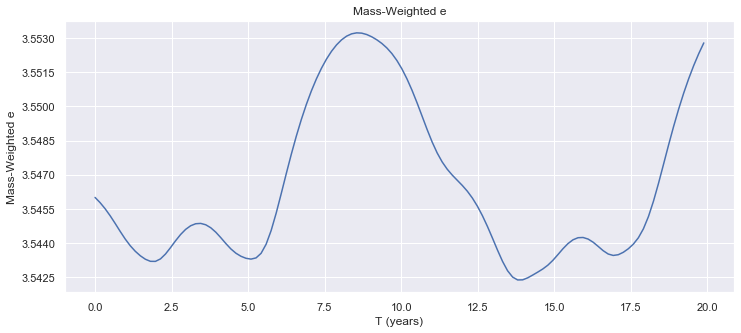

In [65]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, ecc_mass)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(r"Mass-Weighted e")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"Mass-Weighted e")

plt.show()

## Eccentricity vs. Semi-Major Axis vs. Mass

### Snapshots

In [66]:
t  = 0
if include_js or False:
    r_es = r[t]
    v_es = v[t]
    m_es = m[t]
else:
    ind = (m[t] < M_sat).nonzero()[0]
    r_es = r[t][ind]
    v_es = v[t][ind]
    m_es = m[t][ind]

ecc = calc_eccentricity(r_es, v_es, m_es, ms[t])

IndexError: index 125 is out of bounds for axis 0 with size 122

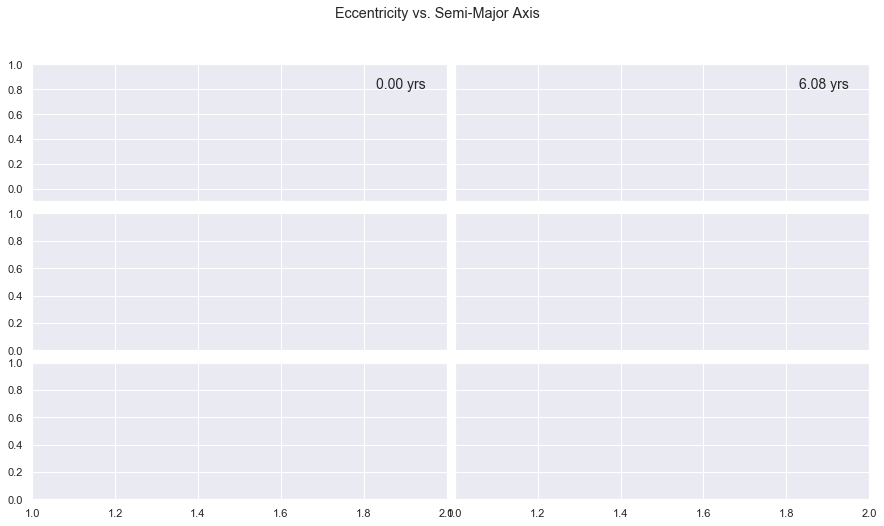

In [67]:
f = 300

local_include = False

t_p = ( 5000 * np.array([0, 3, 10, 30, 100, 399]))//400.#np.linspace(0, len(r) - 1, 6, dtype=int)
t_p = np.array(t_p, dtype=int)
fig, axs = plt.subplots(3, 2, figsize=(15, 8), sharex='col', sharey='row', gridspec_kw={'hspace': 0.09, 'wspace': 0.02})

fig.suptitle('Eccentricity vs. Semi-Major Axis')

for i in range(3):
    for j in range(2):
        t = t_p[2 * i + j]
        if include_js and local_include:
            r_es = r[t]
            v_es = v[t]
            m_es = np.log(m[t])
        else:
            ind = (m[t] < M_sat).nonzero()[0]
            r_es = r[t][ind]
            v_es = v[t][ind]
            m_es = m[t][ind]

        ecc = calc_eccentricity(r_es, v_es, m_es, ms[t])
        sm_axis = calc_semi_major_axis(r_es, v_es, m_es, ms[t]) * LU_to_UA
        
        data = pd.DataFrame.from_dict({"semi_major" : sm_axis[:, 0], "ecc" : ecc[:, 0], "mass" : m_es[:, 0]})
        data.to_excel("data_{}.xlsx".format(t))
        
        axs[i,j].scatter(sm_axis, ecc, alpha=0.70, s=m_es*f*500000)

        axs[i,j].set_ylim(-0.1, 1.0)
#         axs[i,j].set_xlim(0, 4)
        axs[i,j].set_xlim(1, 2)
        
        axs[i,j].annotate(convert_t(tm[t]), xy=(0.95, 0.8), xycoords='axes fraction', fontsize=14,
                horizontalalignment='right', verticalalignment='bottom')
        
        
for ax in axs.flat:
    ax.set(xlabel='Semi-major axis (UA)', ylabel='Eccentrivity (e)')

for ax in axs.flat:
    ax.label_outer()

### Save Images

### Create Gif

In [37]:
# len(r)//6
# t = 5
# f = 400

# local_include = False

# if include_js or local_include:
#     r_es = r[t]
#     v_es = v[t]
#     m_es = m[t]
# else:
#     ind = (m[t] < M_sat).nonzero()[0]
#     r_es = r[t][ind]
#     v_es = v[t][ind]
#     m_es = m[t][ind]

# ecc = calc_eccentricity(r_es, v_es, m_es, ms[t])
# sm_axis = calc_semi_major_axis(r_es, v_es, m_es, ms[t]) * LU_to_UA

# fig, ax = plt.subplots(3, 2, figsize=(15, 8), sharex='col', sharey='row')

# for i in range(3):
#     for j in range(2):
#         ax[i,j].scatter(sm_axis, ecc, alpha=0.70, s=m_es*f*500000)
#         ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='center')

# # ax[0,0].scatter(sm_axis, ecc, alpha=0.70, s=m_es*f*500000)

# plt.show()

# # ax.set_title('Eccentricity vs. Semi-Major Axis {0:04d}'.format(t))
# # ax.set_xlabel('a (UA)')
# # ax.set_ylabel('e')

## Mean Mass

In [68]:
m[0, :, 0] * MU_to_ME

array([9.32849555e-02, 1.29203420e-01, 1.07469725e-01, 1.57688481e-01,
       7.69886746e-02, 1.35535271e-01, 8.26756722e-02, 1.98822347e-01,
       2.51484010e-01, 2.36943135e-01, 1.46564462e-03, 9.38272703e-04,
       1.14248239e-03, 1.58350264e-03, 1.36967641e-03, 1.72192033e-03,
       6.08075806e-04, 6.54610173e-04, 9.91565731e-04, 8.26424527e-04,
       1.33559867e-03, 1.25289901e-03, 1.55667855e-03, 8.10779967e-04,
       1.27354773e-03, 1.64270093e-03, 1.60882496e-03, 1.02054908e-03,
       1.70659319e-03, 6.24712633e-04, 3.17816477e+02, 9.51607502e+01])

In [69]:
calc_eccentricity(r[0], v[0], m[0], ms[0])

array([[0.01990027],
       [0.01990038],
       [0.01990032],
       [0.01990046],
       [0.01990023],
       [0.0199004 ],
       [0.01990024],
       [0.01990059],
       [0.01990074],
       [0.0199007 ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.01990001],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.0199    ],
       [0.01990001],
       [0.0199    ],
       [0.00318999],
       [0.        ]])

In [70]:
calc_semi_major_axis(r[0], v[0], m[0], ms[0]) * LU_to_UA

c:\users\usuario\documents\repos\nbody_planet_formation\NBodyF\core\utils.py:229: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 - h2 / gm * (1. / a))
c:\users\usuario\documents\repos\nbody_planet_formation\NBodyF\core\utils.py:231: RuntimeWarning: invalid value encountered in greater_equal
  a[e >= 1] = n_r[e >= 1]


array([[3.31314195],
       [3.62206137],
       [3.76430194],
       [3.87040768],
       [2.97455786],
       [3.6921862 ],
       [3.87070764],
       [3.79363686],
       [3.13253406],
       [3.51248665],
       [3.05551669],
       [3.450916  ],
       [3.44194558],
       [2.98239441],
       [3.91610321],
       [3.74021591],
       [3.51265515],
       [3.21670095],
       [3.63303479],
       [3.38546703],
       [3.21950884],
       [3.15670222],
       [3.56562193],
       [3.85671018],
       [2.99715771],
       [3.02140906],
       [3.59380273],
       [3.5769569 ],
       [3.80891985],
       [3.88094618],
       [5.18771823],
       [9.5820172 ]])

In [71]:
local_include = False

mean_mass = list()
tl = list()

if include_js or local_include:
    for t in range(len(r)):
        mean_mass.append(np.mean(m[t]) * MU_to_ME)
        tl.append(tm[t])
else:
    for t in range(len(r)):
        ind = (m[t] < M_sat).nonzero()[0]
        mean_mass.append(np.mean(m[t][ind]) * MU_to_ME)
        tl.append(tm[t])

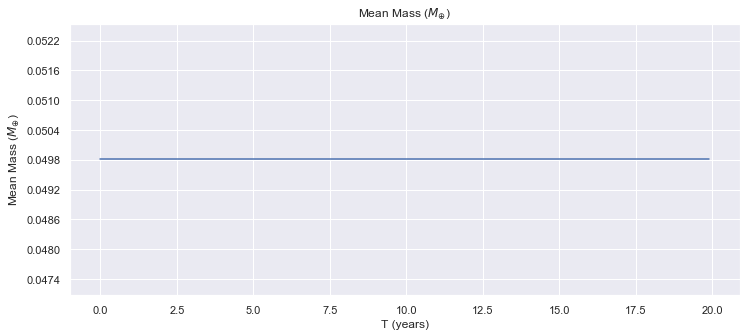

In [72]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, mean_mass)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(r"Mean Mass ($M_{\oplus}$)")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"Mean Mass ($M_{\oplus}$)")

plt.show()

## Max Mass

In [73]:
local_include = False

max_mass = list()
tl = list()

if include_js or local_include:
    for t in range(len(r)):
        max_mass.append(np.max(m[t]) * MU_to_ME)
        tl.append(tm[t])
else:
    for t in range(len(r)):
        ind = (m[t] < M_sat).nonzero()[0]
        max_mass.append(np.max(m[t][ind]) * MU_to_ME)
        tl.append(tm[t])

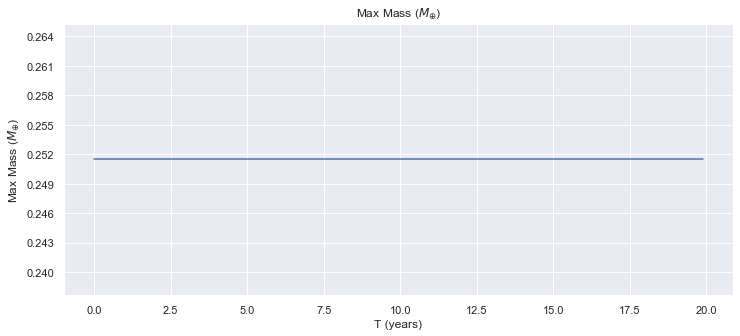

In [74]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, max_mass)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(r"Max Mass ($M_{\oplus}$)")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"Max Mass ($M_{\oplus}$)")

plt.show()

## Total Planetary Mass

In [42]:
Ms= 1.98911*10**33#g #Mass unit
Rs=0.00465047 #Radio solar en UA
Mo= 1.15*10**26/Ms #g

In [43]:
Mo * 0.1

5.781480159468306e-09

In [44]:
local_include = False

total_mass = list()
tl = list()

if include_js or local_include:
    for t in range(len(r)):
        total_mass.append(np.sum(m[t]) * MU_to_ME)
        tl.append(tm[t])
else:
    for t in range(len(r)):
        ind = (m[t] < M_sat).nonzero()[0]
        total_mass.append(np.sum(m[t][ind]) * MU_to_ME)
        tl.append(tm[t])

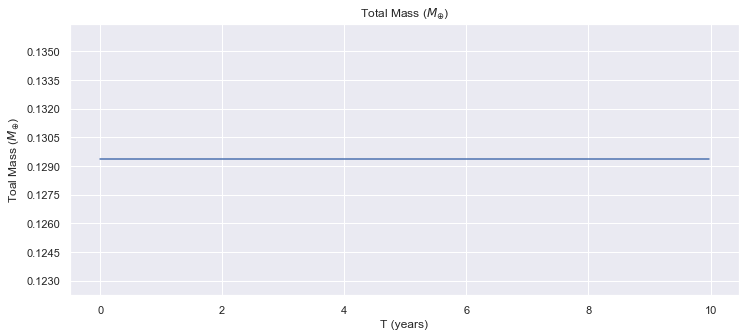

In [45]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, total_mass)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(r"Total Mass ($M_{\oplus}$)")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"Toal Mass ($M_{\oplus}$)")

plt.show()

## Star Mass

In [46]:
star_mass = list()
tl = list()
for t in range(len(r)):
    star_mass.append(ms[t])
    tl.append(tm[t])

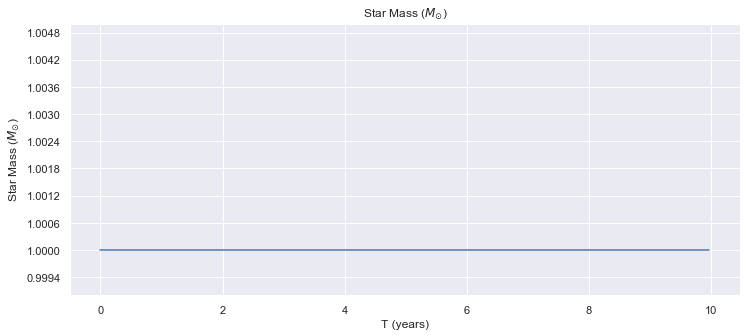

In [47]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tl, star_mass)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(r"Star Mass ($M_{\odot}$)")
ax.set_xlabel('T (years)')
ax.set_ylabel(r"Star Mass ($M_{\odot}$)")
ax.set_ylim([0.999, 1.005])

plt.show()

## Divergent Bodies